In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [31]:
df_1 = pd.read_csv('training/prices_round_1_day_-2.csv' , sep = ';')
df_2 = pd.read_csv('training/prices_round_1_day_-1.csv', sep = ';')
df_3 = pd.read_csv('training/prices_round_1_day_0.csv', sep = ';')
df_1['global_timestamp'] = df_1.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_2['global_timestamp'] = df_2.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_3['global_timestamp'] = df_3.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df = pd.concat([df_1, df_2, df_3])

In [32]:
df_amethyst = df[df['product'] == 'AMETHYSTS'].reset_index()
df_starfruit = df[df['product'] == 'STARFRUIT'].reset_index()

In [33]:
def calculate_vwap(dataframe):
    """
    Calculate an approximate VWAP using multiple levels of order book data.
    
    Parameters:
    - dataframe: A pandas DataFrame with columns for multiple bid and ask prices and volumes.
    
    Returns:
    - vwap: The calculated VWAP as a float.
    """
    # Initialize variables to store the sum of price*volume products and the sum of volumes
    total_price_volume = 0
    total_volume = 0
    dataframe.fillna(0, inplace = True)
    
    # Iterate through the bid and ask levels
    for i in range(1, 4):  # Assuming 3 levels as per your DataFrame structure
        bid_price_col = f'bid_price_{i}'
        bid_volume_col = f'bid_volume_{i}'
        ask_price_col = f'ask_price_{i}'
        ask_volume_col = f'ask_volume_{i}'
        
        # Calculate the product of price and volume for both bid and ask, and add to total
        total_price_volume += (dataframe[bid_price_col] * dataframe[bid_volume_col])
        total_price_volume += (dataframe[ask_price_col] * dataframe[ask_volume_col])
        
        # Sum up the volumes for both bid and ask
        total_volume += dataframe[bid_volume_col]
        total_volume += dataframe[ask_volume_col]
    
    # Calculate and return the VWAP
    vwap = total_price_volume / total_volume
    return vwap


In [34]:
def calculate_imbalance(dataframe):
    flag = 0
    dataframe.fillna(0, inplace = True)
    bid_volume, ask_volume = 0, 0
    
    # Iterate through the bid and ask levels
    for i in range(1, 4):  # Assuming 3 levels as per your DataFrame structure
        bid_volume_col = f'bid_volume_{i}'
        ask_volume_col = f'ask_volume_{i}'
        
        # Calculate the product of price and volume for both bid and ask, and add to total
        
        # Sum up the volumes for both bid and ask
        bid_volume += dataframe[bid_volume_col]
        ask_volume += dataframe[ask_volume_col]
    
    if bid_volume > ask_volume:
        flag = 1
    elif bid_volume < ask_volume:
        flag = -1
    # Calculate and return the VWAP
    return abs(bid_volume - ask_volume), flag

In [35]:
df['vwap'] = df.apply(calculate_vwap, axis = 1)
df_amethyst['vwap'] = df_amethyst.apply(calculate_vwap, axis = 1)
df_starfruit['vwap'] = df_starfruit.apply(calculate_vwap, axis = 1)

### Amethyst

In [36]:
df_amethyst['mid_MA_50'] = df_amethyst['mid_price'].rolling(50).mean()
df_amethyst['mid_MA_30'] = df_amethyst['mid_price'].rolling(30).mean()
df_amethyst['mid_MA_10'] = df_amethyst['mid_price'].rolling(10).mean()

df_amethyst['vwap_MA_50'] = df_amethyst['vwap'].rolling(50).mean()
df_amethyst['vwap_MA_30'] = df_amethyst['vwap'].rolling(30).mean()
df_amethyst['vwap_MA_10'] = df_amethyst['vwap'].rolling(10).mean()

df_amethyst['spread'] = df_amethyst['bid_price_1'] - df_amethyst['ask_price_1']
df_amethyst[['imbalance_volume', 'imbalance_volume_flag']] = df_amethyst.apply(calculate_imbalance, axis = 1, result_type='expand')


df_amethyst['mid_price_diff_1'] = df_amethyst['mid_price'].diff(periods = 1)
df_amethyst['mid_price_diff_5'] = df_amethyst['mid_price'].diff(periods = 5)
df_amethyst['vwap_diff_1'] = df_amethyst['vwap'].diff(periods = 1)
df_amethyst['vwap_diff_5'] = df_amethyst['vwap'].diff(periods = 5)
df_amethyst['imbalance_volume_signed'] = df_amethyst['imbalance_volume'] * df_amethyst['imbalance_volume_flag']


df_amethyst.describe()

,index,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,vwap_MA_30,vwap_MA_10,spread,imbalance_volume,imbalance_volume_flag,mid_price_diff_1,mid_price_diff_5,vwap_diff_1,vwap_diff_5,imbalance_volume_signed
count,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,22311.000000,22311.000000,5141.000000,5141.000000,30000.000000,...,29971.000000,29991.000000,30000.000000,30000.000000,30000.000000,29999.000000,29995.000000,29999.000000,29995.000000,30000.000000
mean,9999.459933,-1.00000,499950.000000,9996.609633,8.218933,9995.290395,19.714939,9995.083252,23.099981,10003.383467,...,9999.997579,9999.997581,-6.773833,2.549067,0.000800,0.000000,-0.000050,0.000000,0.000002,0.015333
std,5773.599086,0.81651,288679.944524,1.937861,10.155552,0.634420,10.142682,0.296664,6.997590,1.949362,...,0.107195,0.183171,2.480219,4.001324,0.696861,2.112182,2.113023,0.812301,0.816592,4.744293
min,0.000000,-2.00000,0.000000,9995.000000,0.000000,9995.000000,1.000000,9995.000000,1.000000,9998.000000,...,9999.283440,9998.849188,-10.000000,0.000000,-1.000000,-7.000000,-7.000000,-7.974265,-7.800000,-28.000000
25%,4999.750000,-2.00000,249975.000000,9995.000000,1.000000,9995.000000,20.000000,9995.000000,22.000000,10004.000000,...,9999.943311,9999.963066,-8.000000,0.000000,0.000000,-1.000000,-1.000000,-0.083660,-0.086957,0.000000
50%,9999.500000,-1.00000,499950.000000,9996.000000,2.000000,9995.000000,23.000000,9995.000000,24.000000,10004.000000,...,9999.999975,9999.999746,-8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14999.250000,0.00000,749925.000000,9996.000000,20.000000,9995.000000,27.000000,9995.000000,27.000000,10005.000000,...,10000.044666,10000.035363,-6.000000,4.000000,0.000000,1.000000,1.000000,0.086957,0.086957,0.000000
max,19999.000000,0.00000,999900.000000,10002.000000,30.000000,10000.000000,30.000000,9998.000000,30.000000,10005.000000,...,10000.492826,10001.221343,-2.000000,28.000000,1.000000,7.000000,7.000000,7.279279,8.515152,28.000000


In [37]:
df_amethyst['mid_price'].max()

10003.5

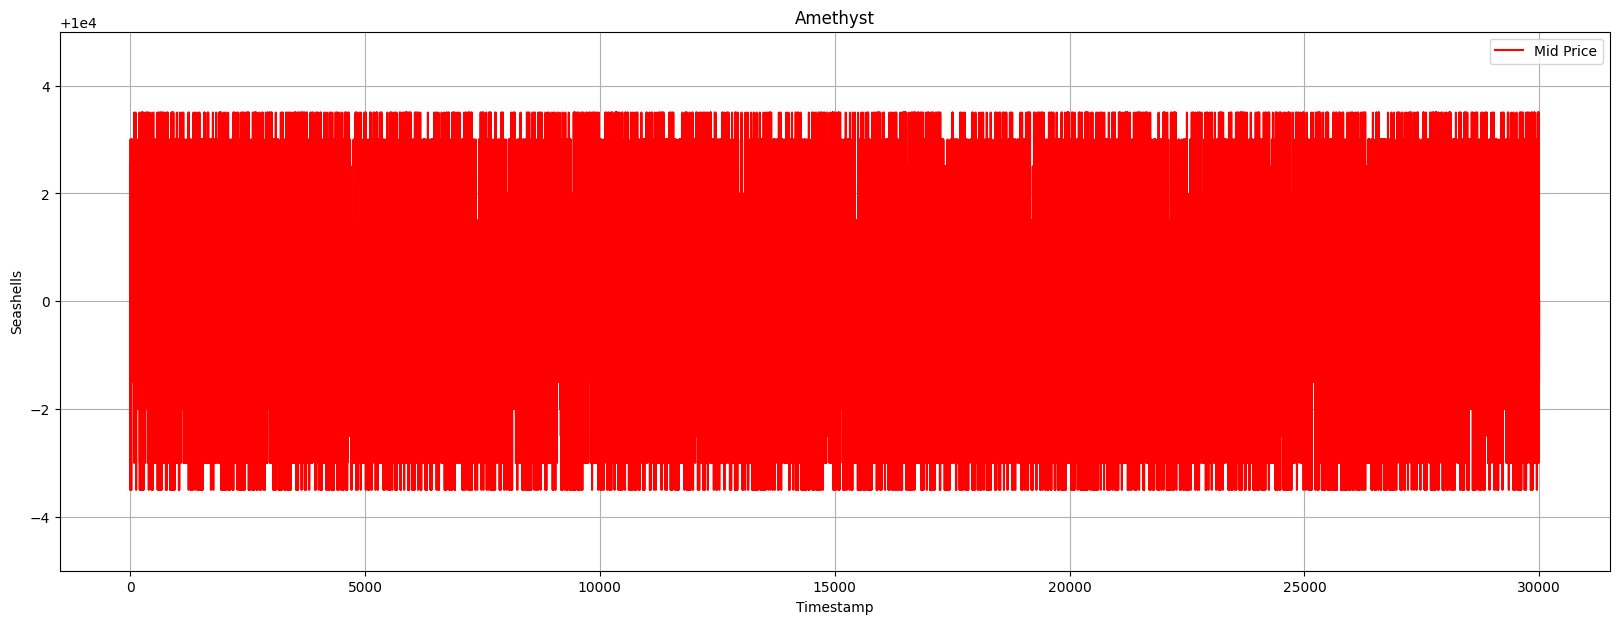

In [38]:
# df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
# plt.plot(df_amethyst['vwap'], label = 'VWAP', color = 'g', linestyle='--')
plt.plot(df_amethyst['mid_price'], label = 'Mid Price', color = 'r')
# plt.plot(df_amethyst['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_50'], label = 'MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')


plt.title('Amethyst')
plt.ylim(9995, 10005)
plt.xlabel('Timestamp')
plt.ylabel('Seashells')
plt.legend()
plt.grid(True)
plt.show()

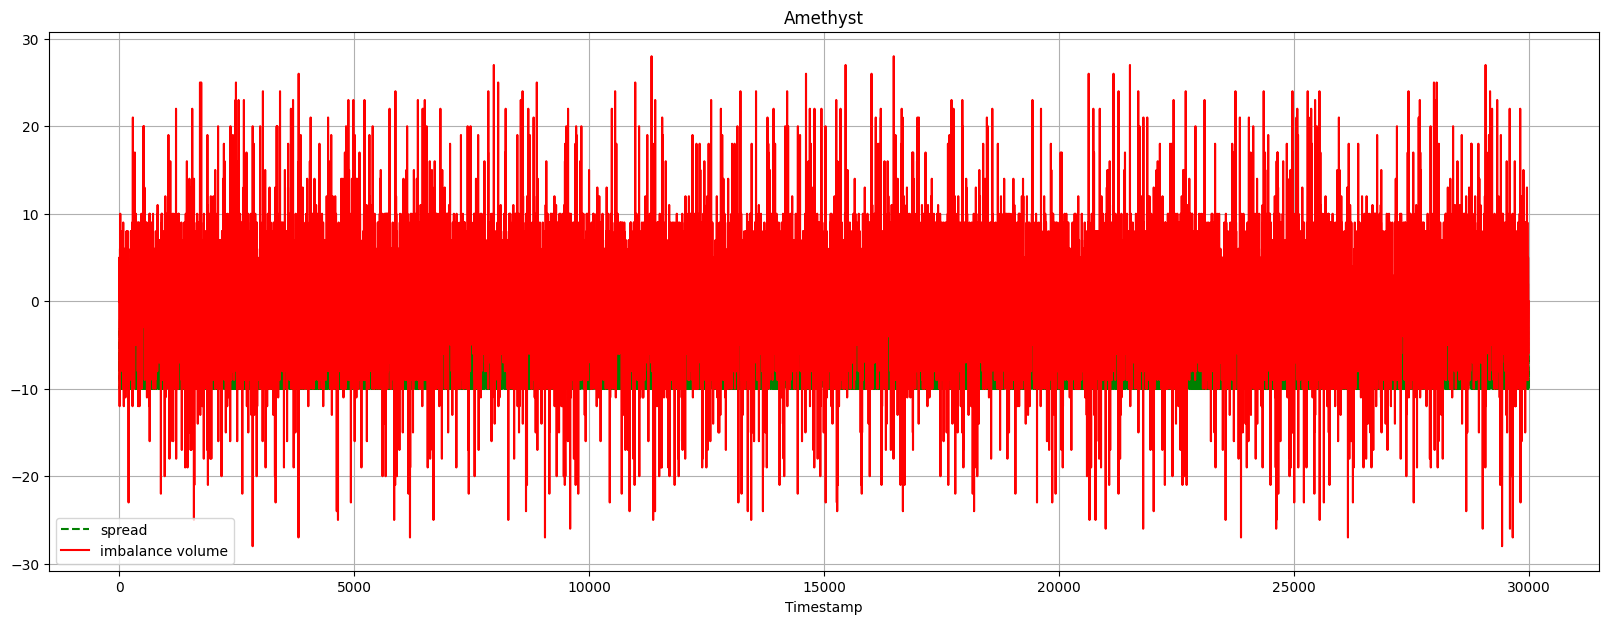

In [39]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(df_amethyst['spread'], label = 'spread', color = 'g', linestyle='--')
plt.plot(df_amethyst['imbalance_volume'] * df_amethyst['imbalance_volume_flag'], label = 'imbalance volume', color = 'r')
# plt.plot(df_amethyst['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_50'], label = 'MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')


plt.title('Amethyst')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.show()

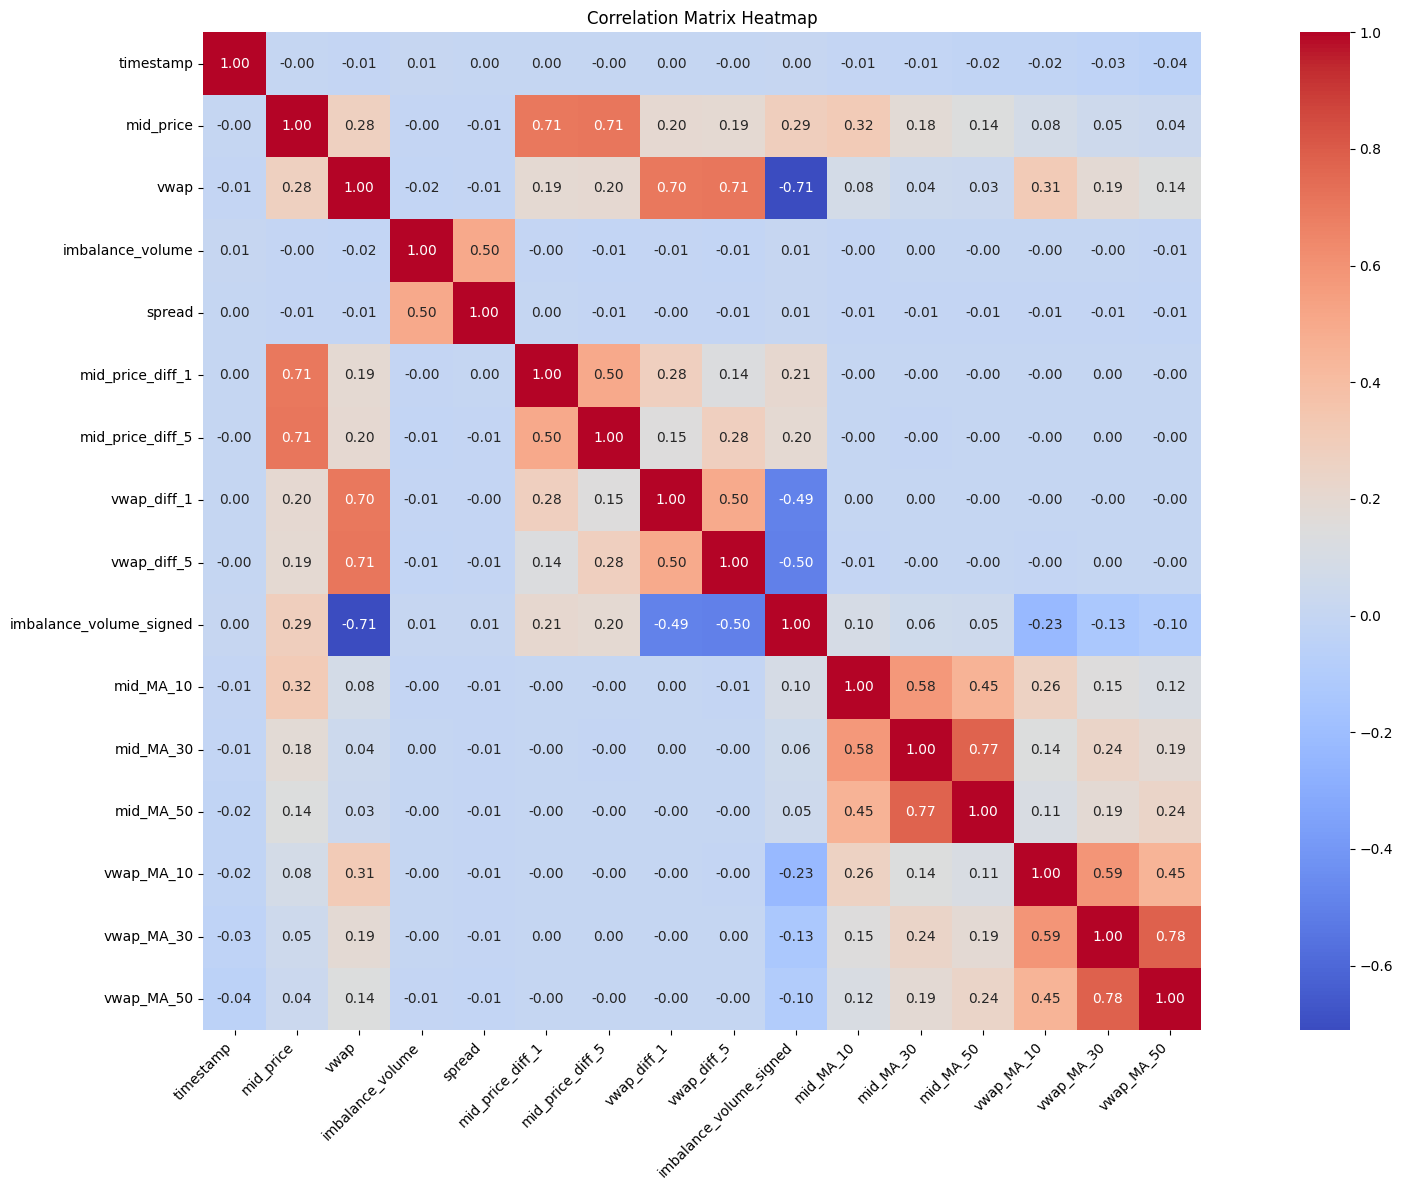

In [40]:

corr_columns = ['timestamp', 'mid_price', 'vwap', 'imbalance_volume', 'spread', 'mid_price_diff_1',
                 'mid_price_diff_5', 'vwap_diff_1', 'vwap_diff_5', 'imbalance_volume_signed', 'mid_MA_10',
                 'mid_MA_30', 'mid_MA_50', 'vwap_MA_10', 'vwap_MA_30', 'vwap_MA_50']
correlation_matrix = df_amethyst[corr_columns].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Adding title and labels
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

### Starfruit

In [41]:
df_starfruit['mid_MA_50'] = df_starfruit['mid_price'].rolling(50).mean()
df_starfruit['mid_MA_30'] = df_starfruit['mid_price'].rolling(30).mean()
df_starfruit['mid_MA_10'] = df_starfruit['mid_price'].rolling(10).mean()

df_starfruit['vwap_MA_50'] = df_starfruit['vwap'].rolling(50).mean()
df_starfruit['vwap_MA_30'] = df_starfruit['vwap'].rolling(30).mean()
df_starfruit['vwap_MA_10'] = df_starfruit['vwap'].rolling(10).mean()

df_starfruit['spread'] = df_starfruit['bid_price_1'] - df_starfruit['ask_price_1']
df_starfruit[['imbalance_volume', 'imbalance_volume_flag']] = df_starfruit.apply(calculate_imbalance, axis = 1, result_type='expand')


df_starfruit['mid_price_diff_1'] = df_starfruit['mid_price'].diff(periods = 1)
df_starfruit['mid_price_diff_5'] = df_starfruit['mid_price'].diff(periods = 5)
df_starfruit['vwap_diff_1'] = df_starfruit['vwap'].diff(periods = 1)
df_starfruit['vwap_diff_5'] = df_starfruit['vwap'].diff(periods = 5)
df_starfruit['imbalance_volume_signed'] = df_starfruit['imbalance_volume'] * df_starfruit['imbalance_volume_flag']



df_starfruit.describe()

,index,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,vwap_MA_30,vwap_MA_10,spread,imbalance_volume,imbalance_volume_flag,mid_price_diff_1,mid_price_diff_5,vwap_diff_1,vwap_diff_5,imbalance_volume_signed
count,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,11281.000000,11281.000000,1257.000000,1257.000000,30000.000000,...,29971.000000,29991.000000,30000.000000,30000.000000,30000.000000,29999.000000,29995.000000,29999.000000,29995.000000,30000.000000
mean,9999.540067,-1.00000,499950.000000,5034.725867,17.231233,5033.924652,23.089354,5034.486078,24.445505,5040.125467,...,5037.419278,5037.411732,-5.399600,2.007067,0.004067,0.001700,0.008585,0.001685,0.008590,0.033200
std,5773.598738,0.81651,288679.944524,32.295106,11.463485,32.358842,7.627033,31.662255,5.550328,32.340010,...,32.262822,32.269235,1.937243,2.875985,0.707625,1.694989,1.869117,0.604718,1.012394,3.506942
min,1.000000,-2.00000,0.000000,4948.000000,1.000000,4948.000000,1.000000,4949.000000,1.000000,4951.000000,...,4952.504133,4951.991690,-8.000000,0.000000,-1.000000,-7.000000,-8.500000,-4.042105,-5.000000,-25.000000
25%,5000.500000,-2.00000,249975.000000,5025.000000,3.000000,5024.000000,22.000000,5024.000000,22.000000,5031.000000,...,5028.108242,5028.101360,-7.000000,0.000000,0.000000,-1.000000,-1.000000,-0.193878,-0.839928,0.000000
50%,10000.000000,-1.00000,499950.000000,5045.000000,23.000000,5045.000000,25.000000,5045.000000,25.000000,5051.000000,...,5048.200708,5048.178722,-6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14999.250000,0.00000,749925.000000,5056.000000,27.000000,5055.000000,28.000000,5056.000000,28.000000,5062.000000,...,5058.923842,5058.908584,-5.000000,4.000000,1.000000,1.000000,1.000000,0.192308,0.872694,1.000000
max,19999.000000,0.00000,999900.000000,5093.000000,32.000000,5092.000000,32.000000,5088.000000,32.000000,5095.000000,...,5090.205600,5091.641176,-1.000000,25.000000,1.000000,7.000000,7.500000,3.968750,4.787120,25.000000


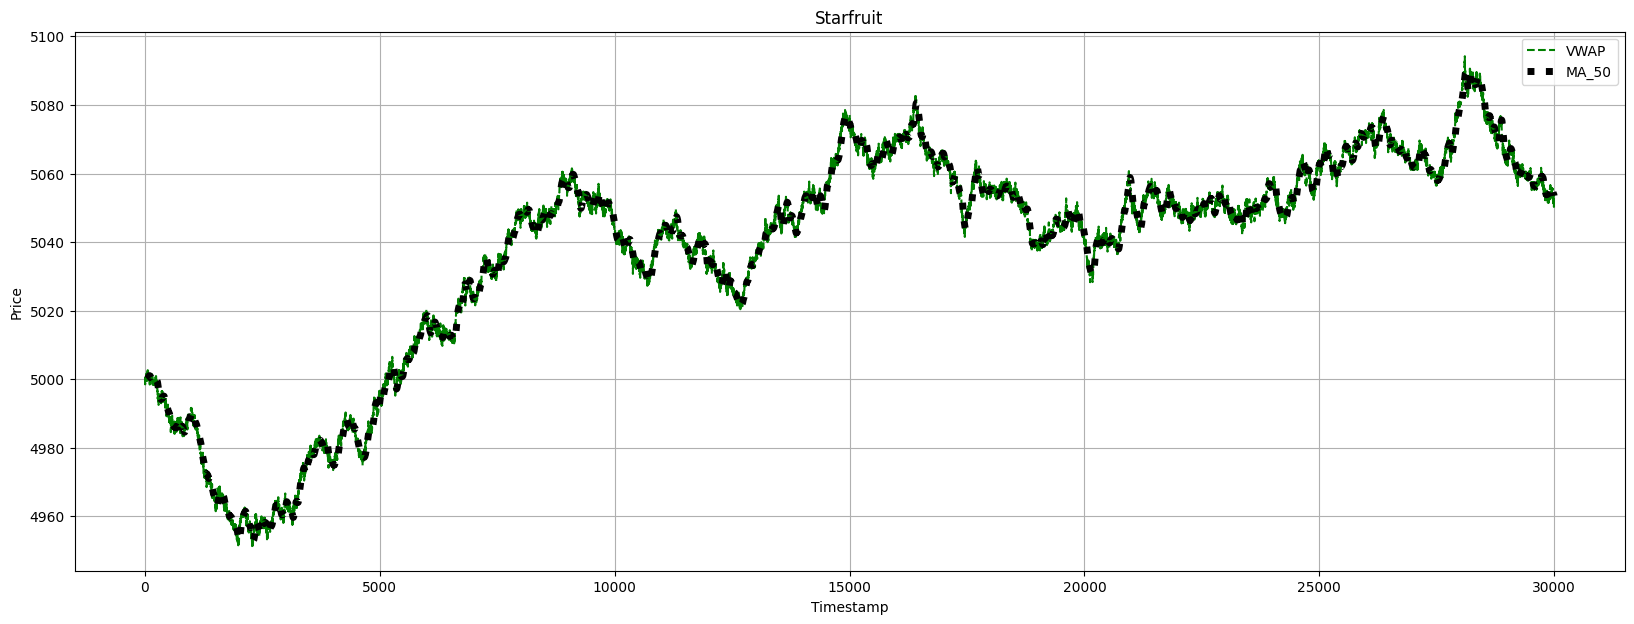

In [58]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(df_starfruit['vwap'], label = 'VWAP', color = 'g', linestyle='--')
#plt.plot(df_starfruit['mid_price'], label = 'Mid Price', color = 'r')
# plt.plot(df_starfruit['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_starfruit['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
plt.plot(df_starfruit['vwap_MA_50'], label = 'vwap_MA_50', color = 'k', linewidth = 5, linestyle = 'dotted')

plt.title('Starfruit')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

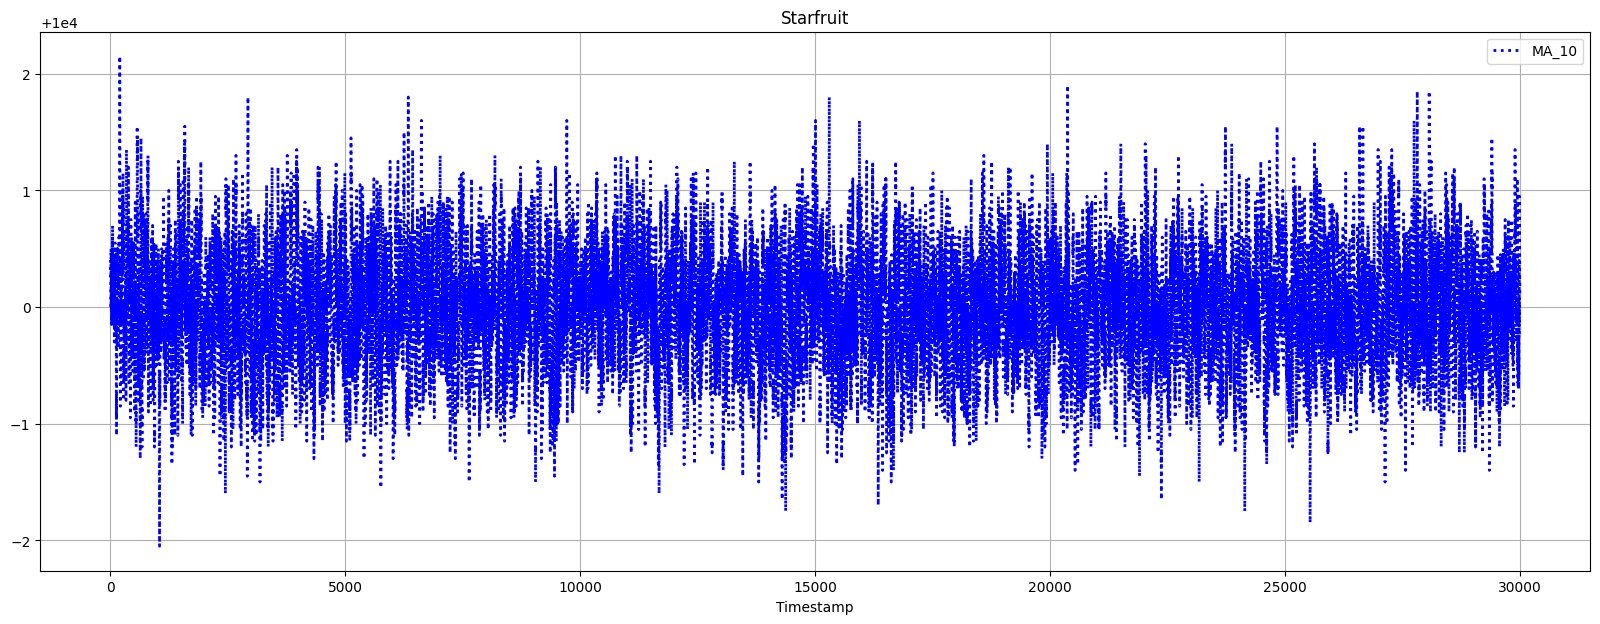

In [56]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
# plt.plot(df_starfruit['spread'], label = 'spread', color = 'g', linestyle='--')
# plt.plot(df_starfruit['imbalance_volume'] * df_amethyst['imbalance_volume_flag'], label = 'imbalance volume', color = 'r')
plt.plot(df_amethyst['mid_MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_50'], label = 'MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')


plt.title('Starfruit')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.show()

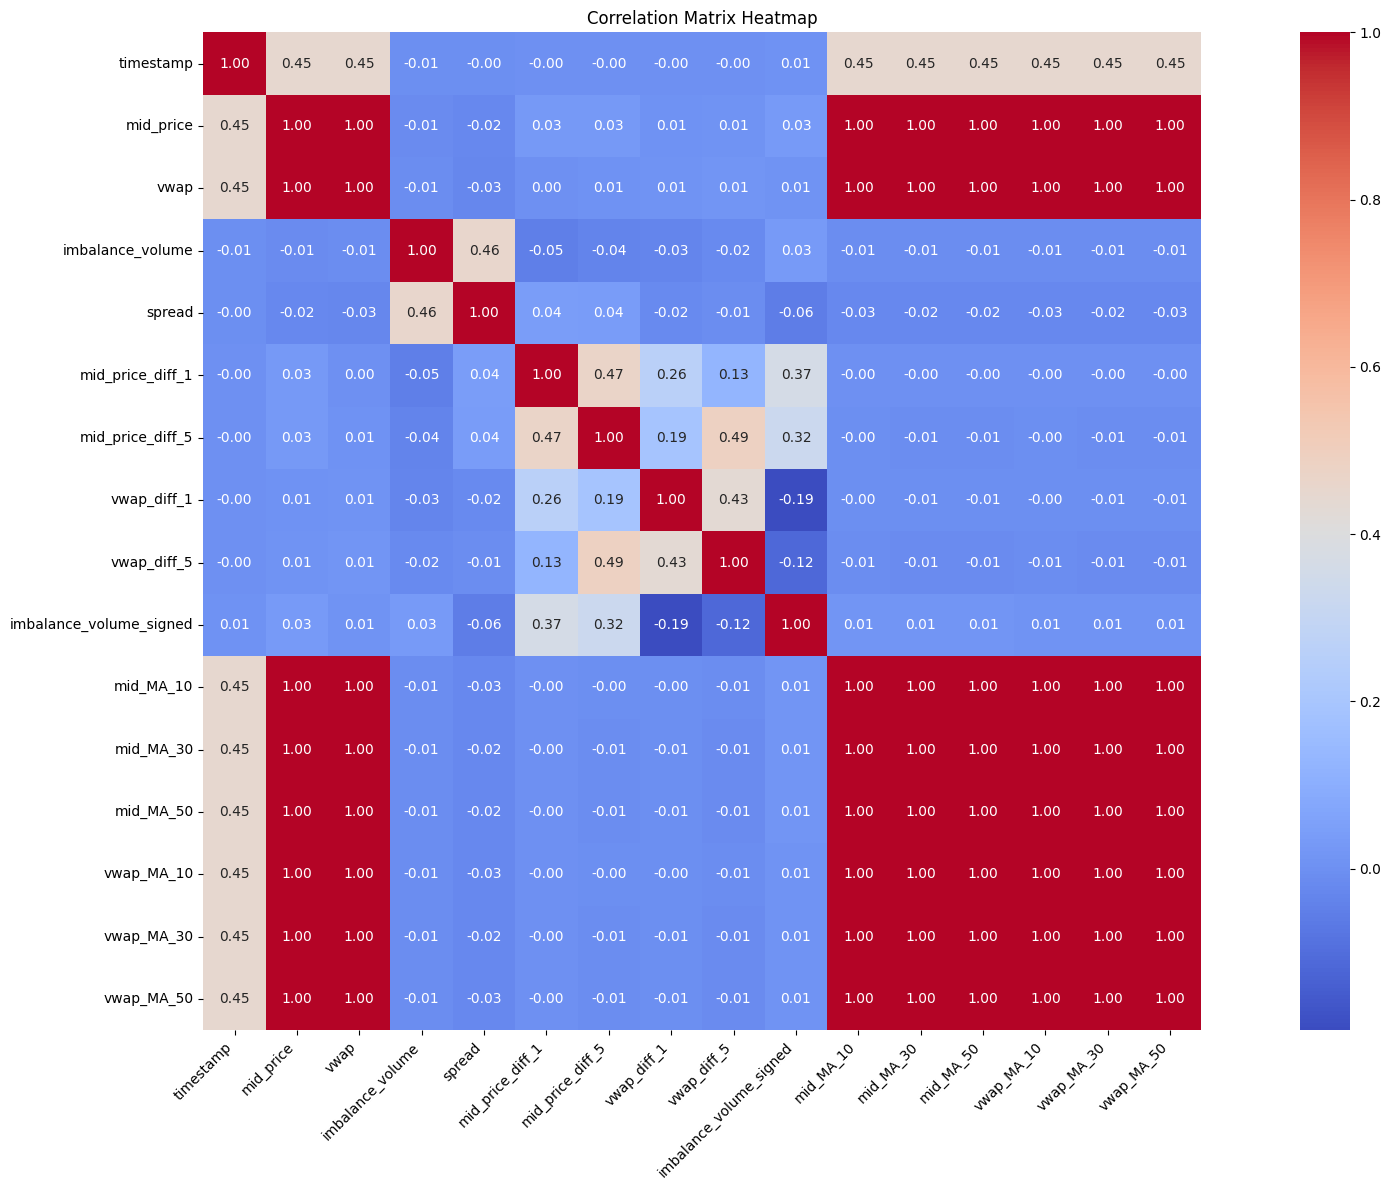

In [57]:
corr_columns = ['timestamp', 'mid_price', 'vwap', 'imbalance_volume', 'spread', 'mid_price_diff_1',
                 'mid_price_diff_5', 'vwap_diff_1', 'vwap_diff_5', 'imbalance_volume_signed', 'mid_MA_10',
                 'mid_MA_30', 'mid_MA_50', 'vwap_MA_10', 'vwap_MA_30', 'vwap_MA_50']
correlation_matrix = df_starfruit[corr_columns].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Adding title and labels
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()